# <div align="center">Same Task, More tokens</div>
##  <div align="center">the Impact of Input Length on the Reasoning Performance of Large Language Models</div>
<div align="center">Mosh Levy<sup id="a1">[*,1]</sup>, Alon Jacoby<sup id="a1">[*,1]</sup>, Yoav Goldberg<sup id="a1">[1,2]</sup></div> 

## What is this all about?
We explore the impact of extending input lengths on the capabilities of Large Language Models (LLMs). 

Despite LLMs advancements in recent times, their performance consistency across different input lengths is not well understood.

Here, we aim to change that by isolating the effect of input length and studying when, and how models fail to respond correctly to QA reasoning tasks.

## How to investigate the impact of length
We investigate this aspect by introducing a novel QA reasoning framework, our [**FLenQA Dataset**](https://github.com/alonj/Same-Task-More-Tokens/), specifically designed to assess the impact of input length. We isolate the effect of input length using multiple versions of the same sample, each being extended with padding of different lengths, types and locations.

## What we found
Our findings show a notable degradation in LLMs' reasoning performance at much shorter input lengths than their technical maximum. We show that the degradation trend appears in every version of our dataset, although at different intensities.

Additionally, our study reveals that the traditional metric of next word prediction correlates negatively with performance of LLMs' on our reasoning dataset.

We also identified failure modes that can serve as useful guides for future research, potentially informing strategies to address the limitations observed in LLMs.

## This notebook
This notebook should help you analyse and evaluate models of your choice. We demonstrate all the necessary steps on GPT-3.5 Turbo (Version 1106)

- In [Part 1](#loading-the-data), we show how to load the data, and the prompts we used for each task within our dataset. Change the prompts and experiment!
- In [Part 2](#getting-model-responses-for-our-flenqa-dataset), we get results from the model of our choice (example includes GPT-3.5 Turbo) and perform all the basic processing steps needed for our analysis later.
- In [Part 3](#base-results), we have basic plots to visualize how model accuracy declines over longer input.
- In [Part 4](#chain-of-thought-analysis), we perform the kind of analysis we have in our paper on Chain-of-Thought prompting.


<sub id="f1">*</span>: Authors contributed equally to this work.  
<span id="f2">1</span>: Bar-Ilan University  
<span id="f2">2</span>: Allen Institute for AI  

In [1]:
# Imports
import string, re, os
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

Matplotlib is building the font cache; this may take a moment.


<a id='load'></a>
# Loading the Data

Our dataset is formatted as a list of JSONs (i.e jsonl format). Each JSON has the following structure:
- `global_sample_id`: A unique identifier for each sample across multiple datasets.
- `sample_id`: A unique identifier for each sample in a single task.
- `label`: A boolean value that represents the target variable (True/False).
- `dataset`: A string that likely indicates the name or type of the dataset this sample belongs to.
- `facts`: For the PIR/MonoRel tasks: A list of strings that the model needs to identify in the prompt and reason over to generate the correct response.
- `rule`: For the Simplified Ruletaker task: A list of strings that the model needs to identify in the prompt and reason over, in conjunction with the `statement` string, to generate the correct response..
- `statement`: For the Simplified Ruletaker task: A statement that holds in conjunction with the `rule`.
- `assertion/question`: A question or assertion about the sample.
- `mixin`: A mix of the facts and the padding. Basis of the prompt, *without prompt instructions*.
- `padding_type`: The type of padding used in the sample.
- `dispersion`: The type of dispersion used to place the facts in the prompt text (e.g mixin).
- `ctx_size`: The target size of the mixin.

In [3]:
dataset_url = './FLenQA.zip'
data = pd.read_json(dataset_url, orient='records', lines=True)

In [4]:
prompt_structures = {

"Simplified RuleTaker": 
    lambda sample: f"""\
Answer whether the statement {sample['assertion/question']} can be derived from the rule and the facts. Answer with either "True" or "False".
Rule: {sample['rule']}
Facts: {sample['mixin']}
Answer with either "True or "False".
""",

"Simplified RuleTaker_cot": 
    lambda sample: f"""\
Answer whether the statement {sample['assertion/question']} can be derived from the rule and the facts.
Show your steps then answer with either "True" or "False".
Rule: {sample['rule']}
Facts: {sample['mixin']}
Answer with either "True or "False". Let's work this out in a step by step way to be sure we have the right answer.
""",

"PIR":
    lambda sample: f"""\
{sample['mixin']}
True/False Question: {sample['assertion/question']}
Answer only True or False.
""",

"PIR_cot":
    lambda sample: f"""\
Show your steps then answer with ’true’ or ’false’.
{sample['mixin']}
True/False Question: {sample['assertion/question']}
Let’s work this out in a step by step way to
be sure we have the right answer.
""",

"MonoRel": 
    lambda sample: f"""\
Here are some facts. Answer the exact following question based on the text: {sample['assertion/question']} Answer the question as it appears exactly.
{sample['mixin']}
{sample['assertion/question']}
Answer only True or False.
""",

"MonoRel_cot": 
    lambda sample: f"""\
Here are some facts. Answer the exact following question based on the text: {sample['assertion/question']} Answer the question as it appears exactly.
Show your steps then answer with ’true’ or ’false’.
{sample['mixin']}
{sample['assertion/question']}
Let’s work this out in a step by step way to be sure we have the right answer. Show your work and finally answer with ’true’ or ’false’. The final step should include the exact text of the question and the answer.
""",

}

# Getting model responses for our FLenQA dataset

We provide here an example of a call wrapper for OpenAI's GPT 3.5 model, feel free test any model with its API, or modify the code accordingly to run with locally deployed models. Note that we fix the temperature to be 0.

In [11]:
from openai import OpenAI
import dotenv

dotenv.load_dotenv()

client = OpenAI()

def gpt_wrapper(sample_text, model='gpt-4o', max_output_tokens=400):
    """
    Wrapper for OpenAI API

    Args:
    sample_text: string for chat input
    model: model name
    max_output_tokens: maximum number of tokens in the response

    Returns:
    response string
    """
    response = client.chat.completions.create(
            model=model,
            messages=[
                {
                "role": "user",
                "content": sample_text
                }
            ],
            temperature=0,
            max_tokens=max_output_tokens,
            top_p=0,
            frequency_penalty=0,
            presence_penalty=0
        )
    return response.choices[0].message.content

In [12]:
def normalize_answer(s):
    """
    Lower text and remove punctuation, articles and extra white spaces

    Args:
    s: string to normalize

    Returns:
    normalized string
    """
    s = str(s).lower()
    s = s.replace("".join(list(set(string.punctuation))), '')
    s = re.sub(r'\b(a|an|the)\b', ' ', s)
    s = ' '.join(s.split())
    return s

def response_category(ans):
    """
    Categorize the answer as true, false or other/refused
    
    Args:
    ans: string to categorize
    
    Returns:
    string category
    """
    if isinstance(ans, (bool, np.bool_)):
        return normalize_answer(str(ans))
    if isinstance(ans, str):
        ans = normalize_answer(ans)
        ans = ans.replace('not true', 'false')
        last_true_pos = ans.rfind('true')
        last_false_pos = ans.rfind('false')
        if last_true_pos > last_false_pos:
            return 'true'
        elif last_false_pos > last_true_pos:
             return 'false'
    return 'other/refused'

def get_response(sample, model_wrapper_func, model_kwargs={}, chain_of_thought=False):
    """
    Get response from the model
    
    Args:
    sample: dictionary with sample information
    model_wrapper_func: function to call the model
    chain_of_thought: whether to use chain of thought or not
    
    Returns:
    string response
    """
    prompt = prompt_structures[sample['dataset'] + ('_cot' if chain_of_thought else '')](sample)
    response = model_wrapper_func(prompt, **model_kwargs)
    return response
    
def response_analysis(sample, response, chain_of_thought=False):
    """
    Analyze the response and compare it to the sample

    Args:
    sample: dictionary with sample information
    response: string response

    Returns:
    dictionary with analysis results
    """
    normalized_response_text = normalize_answer(response)
    categorical_response = response_category(normalized_response_text)
    correctness = categorical_response is not None and categorical_response in sample['label'].lower()
    if chain_of_thought:
        if sample['dataset'] != 'Simplified RuleTaker': # Ruletaker has statements instead of facts
            cot_coverage = sum([normalize_answer(fact) in normalized_response_text for fact in sample['facts']])
        else:
            cot_coverage = sum([normalize_answer(fact) in normalized_response_text for fact in sample['statement']])
        early_response = categorical_response is not None and categorical_response in normalized_response_text[:10].lower()
    else:
        cot_coverage = 0
        early_response = False
    return {
        'response': response,
        'cot_coverage': cot_coverage,
        'normalized_response': categorical_response,
        'correct': correctness,
        'early_response': early_response,
    }

In [22]:
models = ['gpt-4o', 'chatgpt-4o-latest']

responses = []
for chain_of_thought in [True, False]:
    for model in models:
        for sample in tqdm(data.to_dict(orient='records')[:500]):
            response = get_response(
                sample, 
                gpt_wrapper, 
                chain_of_thought=chain_of_thought, 
                model_kwargs={'model': model,
                            'max_output_tokens': 400}
            )

            response = response_analysis(sample, response, chain_of_thought=chain_of_thought)
            
            response.update({
                'model': model,
                'dataset': sample['dataset'],
                'sample_dataset_id': sample['sample_id'],
                'sample_global_id': sample['global_sample_id'],
                'label': sample['label'],
                'dispersion': sample['dispersion'],
                'padding_type': sample['padding_type'],
                'ctx_size': sample['ctx_size'],
                'chain_of_thought': chain_of_thought,
            })
            responses.append(response)
responses = pd.DataFrame(responses)

100%|██████████| 500/500 [04:31<00:00,  1.84it/s]


In [24]:
# display the first 5 responses
responses.tail(5)

,response,cot_coverage,normalized_response,correct,early_response,model,dataset,sample_dataset_id,sample_global_id,label,dispersion,padding_type,ctx_size,chain_of_thought
1995,True,0,true,True,False,chatgpt-4o-latest,PIR,12,12,True,random,books,250,False
1996,True,0,true,True,False,chatgpt-4o-latest,PIR,12,12,True,random,books,500,False
1997,True,0,true,True,False,chatgpt-4o-latest,PIR,12,12,True,random,books,1000,False
1998,True,0,true,True,False,chatgpt-4o-latest,PIR,12,12,True,random,books,2000,False
1999,True,0,true,True,False,chatgpt-4o-latest,PIR,12,12,True,random,books,3000,False


# Base Results

Let's visualize the results we have from our model.

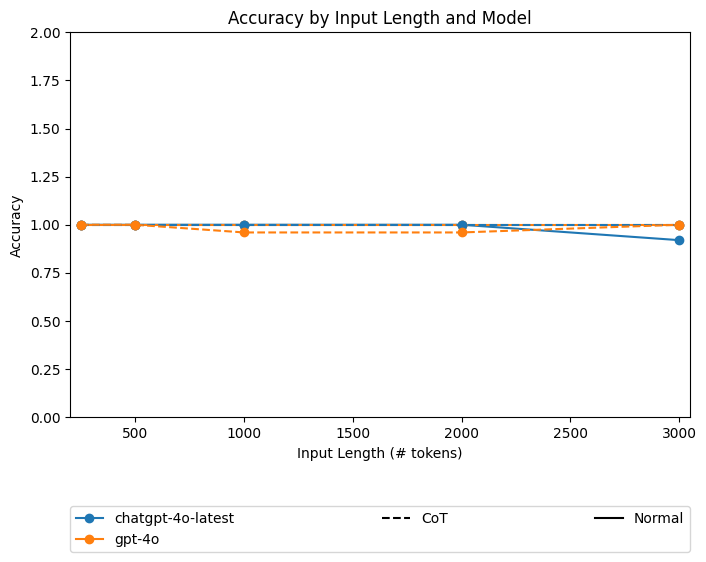

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))
filtered_responses = responses[(responses['padding_type'] != 'identity') & (responses['dispersion'] == 'random')]

# Non COT plot
df = filtered_responses[~filtered_responses['chain_of_thought']]
df.groupby(['ctx_size', 'model'])['correct'].mean().unstack().plot(kind='line', ax=ax, marker='o', linestyle='-')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

handles, labels = ax.get_legend_handles_labels()

# COT plot
if True in filtered_responses['chain_of_thought'].unique():
    df = filtered_responses[filtered_responses['chain_of_thought']]
    df.groupby(['ctx_size', 'model'])['correct'].mean().unstack().plot(kind='line', ax=ax, marker='o', linestyle='--', color=colors)
    faux_plot1, = ax.plot([1], marker='None', linestyle='--', color='black', label='CoT')
    faux_plot2, = ax.plot([1], marker='None', linestyle='-', color='black', label='Normal')
    handles.extend([faux_plot1, faux_plot2])
    labels.extend(['CoT', 'Normal'])

ax.set_xlabel('Input Length (# tokens)')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Input Length and Model')
ax.set_xlim(200, 3050)
ax.set_ylim(0, 2)

ax.legend(handles, labels, loc='lower center',bbox_to_anchor=(0., -0.35, 1., .102), ncol=3, mode="expand", borderaxespad=0.)

TypeError: no numeric data to plot

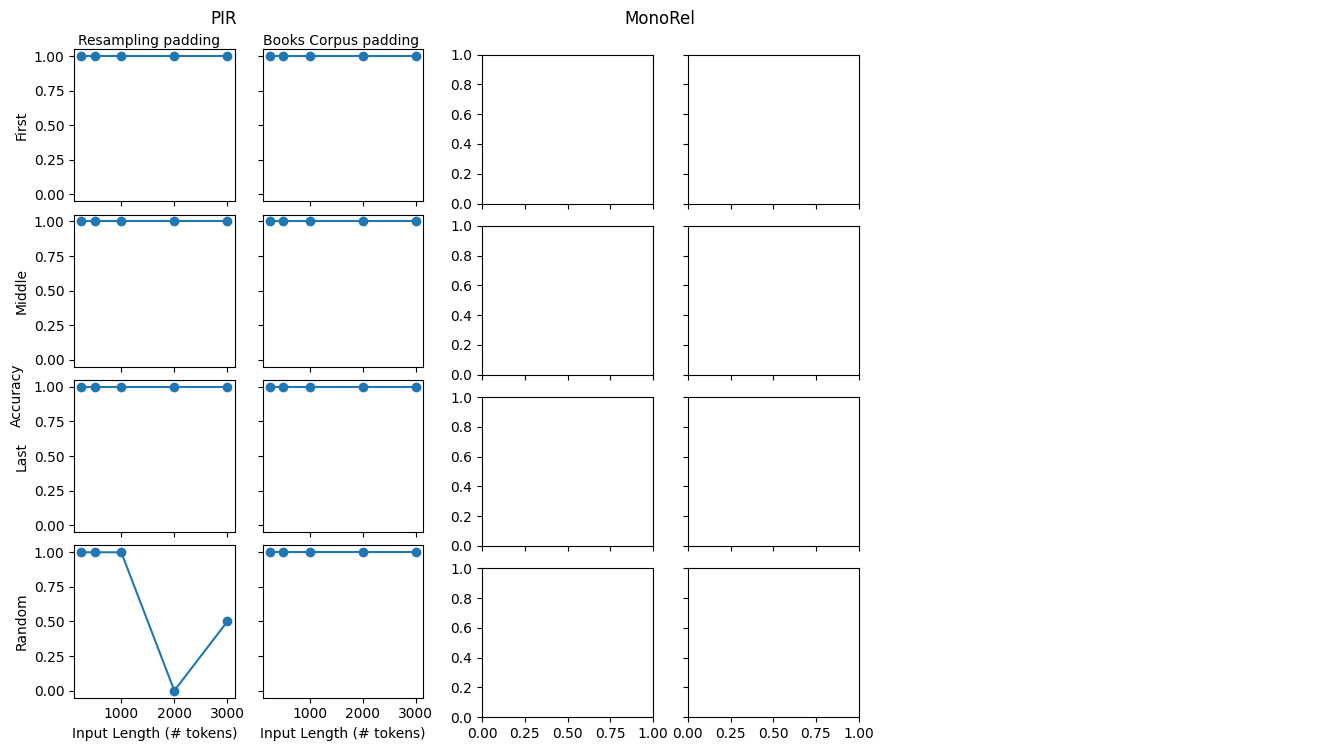

In [20]:
main_fig = plt.figure(constrained_layout=True, figsize=(13, 7))
subfigs = main_fig.subfigures(1, 3)
for dataset, (subfig_i, subfig) in zip(['PIR', 'MonoRel', 'Simplified RuleTaker'], enumerate(subfigs)):
    subfig.suptitle(dataset, x=0.5, y=1.05)
    dataset_data = responses[responses['dataset'] == dataset]
    axes = subfig.subplots(4, 2, sharex=True, sharey=True)
    for i, dispersion in enumerate(['first', 'middle', 'last', 'random']):
        dispersion_data = dataset_data[dataset_data['dispersion'] == dispersion]
        for j, padding_type in enumerate(['same', 'books']):
            df = dispersion_data[dispersion_data['padding_type'] == padding_type]
            ax = axes[i, j]

            # Group by sample length and model name, then calculate the mean accuracy for each group and plot it
            df.groupby(['ctx_size', 'model'])['correct'].mean().unstack().plot(kind='line', ax=ax, marker='o')

            ax.set_xlabel('Input Length (# tokens)')
            if j == 0 and subfig_i == 0:
                ax.set_ylabel(dispersion.title())
            ax.get_legend().remove()
    for ax in axes[:, 1]:
        ax.set_ylabel('')

    if subfig_i == 0:
        subfig.text(.0, .5, 'Accuracy', va='center', rotation='vertical')
    subfig.text(.325, 1., 'Resampling padding', ha='center')
    subfig.text(.775, 1., 'Books Corpus padding', ha='center')
handles, labels = ax.get_legend_handles_labels()
main_fig.legend(handles, labels, loc='lower center',bbox_to_anchor=(0., -0.05, 1., .102), ncol=3, mode="expand", borderaxespad=0.)

As we can see in these GPT3.5 results, in most cases, the model suffers a large hit to accuracy as input length grows. See Section 4 in our paper for full discussion.

# Chain-of-Thought Analysis

Here we analyse some of the patterns in the Chain-of-Thought responses. See full discussion in out paper in Section 6.

In [9]:
from scipy.stats import fisher_exact

In [10]:
df = responses[responses['chain_of_thought']]
df['coverage_failure'] = df['cot_coverage'] < 2
contingency_mat = pd.crosstab(df.coverage_failure, df.correct)
# reverse the contingency matrix rows
contingency_mat = contingency_mat.iloc[::-1]
result = fisher_exact(contingency_mat.values, 'greater')
print("CoT failures dependency on incorrectness for GPT-3.5 Turbo\nShown are the p-values for the Fisher's exact test for the dependence of the failure modes on incorrectness.")
print("Coverage Failure / Incorrectness dependency: ", result.pvalue)

contingency_mat = pd.crosstab(df.early_response, df.correct)
# reverse the contingency matrix rows
contingency_mat = contingency_mat.iloc[::-1]
result = fisher_exact(contingency_mat.values, 'greater')
print("Early Response / Incorrectness dependency: ", result.pvalue)

CoT failures dependency on incorrectness for GPT-3.5 Turbo
Shown are the p-values for the Fisher's exact test for the dependence of the failure modes on incorrectness.
Coverage Failure / Incorrectness dependency:  1.3734773437647794e-39
Early Response / Incorrectness dependency:  3.128923356391785e-33


Text(0.5, 1.0, 'Bias in answer generation, \nand non-answers')

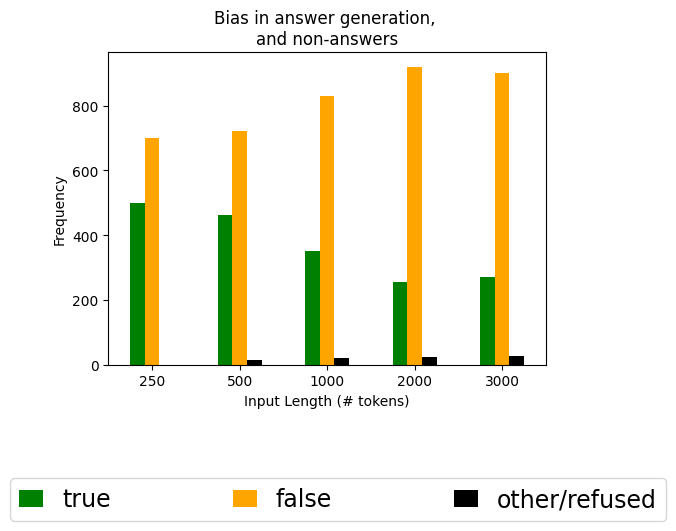

In [11]:
# plot answer frequency per model, at each ctx_size
fig, ax = plt.subplots(figsize=(7,5))
df = responses.groupby(['ctx_size', 'normalized_response'])['model'].count().unstack().sort_index()

# convert nans to 0
df.fillna(0, inplace=True)
df = df[['true', 'false', 'other/refused']]
df.plot(kind='bar', stacked=False, ax=ax, color=['green', 'orange', 'black'], rot=0)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(-0.225, -0.5, 1.5, .102), loc='lower left', ncol=3, mode="expand", borderaxespad=0., fontsize=17, handlelength=1)
fig.subplots_adjust(left=0.175, right=0.8, bottom=0.175, top=0.8)
ax.set_xlabel('Input Length (# tokens)')
ax.set_ylabel('Frequency')
ax.set_title(f'Bias in answer generation, \nand non-answers')

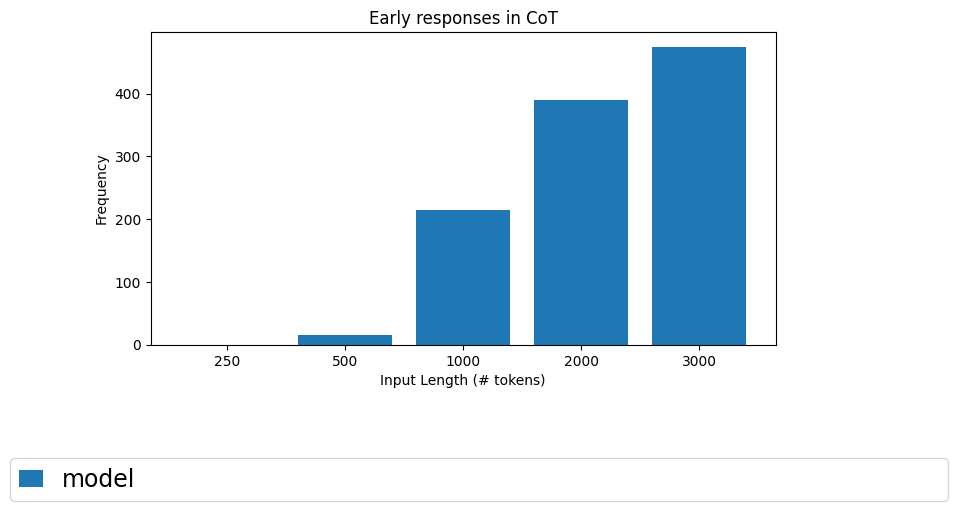

In [13]:
filtered_responses = responses[responses['chain_of_thought']]
filtered_responses = filtered_responses[filtered_responses['early_response']]
# plot early response rate per model, at each ctx_size
fig, ax = plt.subplots(figsize=(10,5))
filtered_responses = filtered_responses.groupby(['ctx_size']).count()['model']
for i in [250, 500, 1000, 2000, 3000]:
    if i not in filtered_responses.index:
        filtered_responses.loc[i] = 0
filtered_responses.sort_index(inplace=True)
filtered_responses.plot(kind='bar', stacked=False, ax=ax, rot=0, width=0.8)
# sort legend alphabetically
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(-0.225, -0.5, 1.5, .102), loc='lower left', ncol=3, mode="expand", borderaxespad=0., fontsize=17, handlelength=1)
fig.subplots_adjust(left=0.175, right=0.8, bottom=0.175, top=0.8)
ax.set_xlabel('Input Length (# tokens)')
ax.set_ylabel('Frequency')
ax.set_title(f'Early responses in CoT');

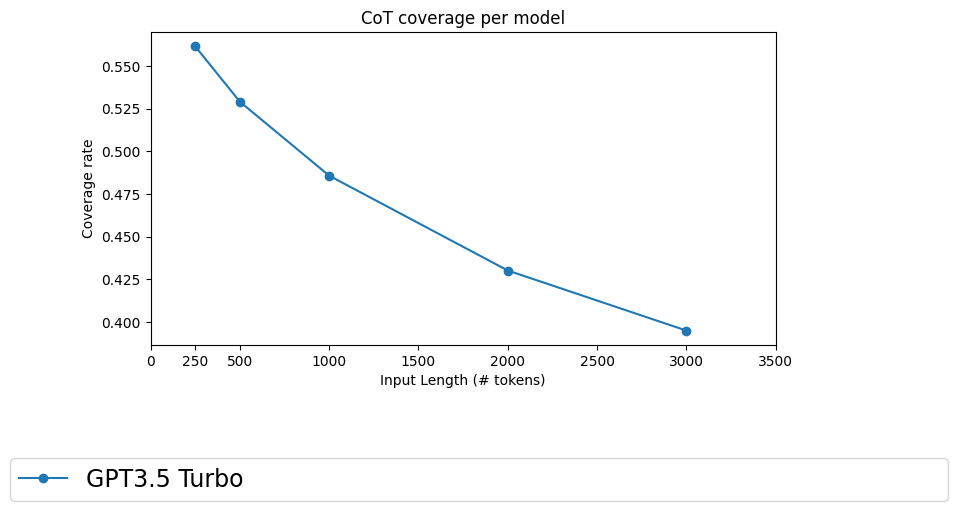

In [14]:
filtered_responses = responses[responses['chain_of_thought']]
fig, ax = plt.subplots(figsize=(10,5))
(filtered_responses.groupby(['ctx_size', 'model'])['cot_coverage'].mean().unstack() / 2).plot(kind='line', ax=ax, marker='o')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(-0.225, -0.5, 1.5, .102), loc='lower left', ncol=3, mode="expand", borderaxespad=0., fontsize=17)
fig.subplots_adjust(left=0.175, right=0.8, bottom=0.175, top=0.8)
ax.set_xticks(list(ax.get_xticks()) + [250])
ax.set_xlabel('Input Length (# tokens)')
ax.set_ylabel('Coverage rate')
ax.set_title(f'CoT coverage per model');